## Modules à importer

In [1]:
import math
import scipy
import pickle
import sncosmo
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from importlib import reload
from variaIa import baserate
from variaIa import stretchevol
from scipy.stats import poisson
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
import random

## Définitions et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../../Data/data_cheat.csv', sep=' ', index_col='CID')
d_snf = pd.read_csv('../../Data/lssfr_paper_full_sntable.csv', sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value='PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])],
        'survey_all': d[d['IDSURVEY'].isin([1, 15, 4])]}

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
    
int_data = ipw.interactive(set_data, su=su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

# Détermination des $z_{\text{max}}$ _via_ SNcosmo

#### For every (x1, c) in an ([-3, 3], [-0.3, 0.3]) ellipse, we want to find the absolute magnitude 5 days prior to the peak value taken at -19.3: M is indeed a function of (x1, c, t).

#### We set the SN near z=0, with c and x1 to 0 for that is the value that will give the actual peak absolute magnitude, and then we get M by taking the apparent magnitude it has, minus the distance modulus.

In [3]:
M_list = []
model = sncosmo.Model("salt2")
model.set(z=0.00000001, t0=55000, c=0., x1=0)
model.set_source_peakabsmag(-19.36, "bessellb", "ab", cosmo=Planck15)

a=3.     #radius on the x-axis
b=.3    #radius on the y-axis
t = np.linspace(0, 2*np.pi, 10000)

data = dict()

for i in range(len(t)):
    data[i] = {'c': b*np.sin(t)[i],
               'x1': a*np.cos(t)[i]}
    model.update(data[i])
    data[i]['M'] = model.bandmag('bessellb', 'ab', model["t0"]-5)\
                 - Planck15.distmod(model["z"]).value

df = pd.DataFrame(data).T

#### The effective instrinsec magnitude also depends linearly on (x1, c) according to the Tripp equation, and as such we correct for that.
#### α is taken at 0.158, and β at 3.138 according to Scolnic 2018a, table 7

In [4]:
df['M_eff'] = df['M']-0.158*df['x1']+3.138*df['c']

## Plotting the results

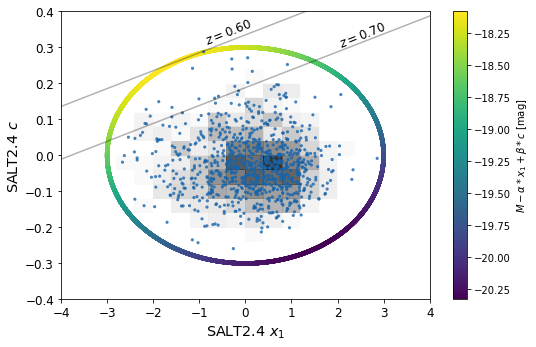

In [73]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ts = ax.scatter(df['x1'],
                df['c'],
                marker='o',
                cmap='viridis',
                c=df['M_eff'], edgecolors="None",
                s=20,
                zorder=2)

cl = fig.colorbar(ts, label=r'$M-\alpha*x_1 + \beta*c$ [mag]')

ax.hist2d(surv['survey_all'].x1,
          surv['survey_all'].c,
          range=[[-4, 4], [-.4, .4]],
          bins=20,
          cmap=plt.cm.binary,
          vmin=1,
          alpha=.8)

ax.scatter(surv['survey_all'].x1,
           surv['survey_all'].c,
           marker='.',
           fc=plt.cm.Blues(.8, .8),
           edgecolors="None",
           lw=.5,
           s=40,
           zorder=2)

ax.tick_params(labelsize=12)

ax.set_xlabel(r'SALT2.4 $x_1$', fontsize='x-large')
ax.set_ylabel(r'SALT2.4 $c$', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

fig.savefig('../../../../Images/zmax_maglim_all.pdf')

#ax.scatter(df.sort_values('M_eff', ascending=False).iloc[0]['x1'],
#           df.sort_values('M_eff', ascending=False).iloc[0]['c'],
#           color='k',
#           marker='+', s=100, zorder=8)

m_lim = 24.8
M_min = -19.00
x = np.linspace(-4, 4, 4000)
z = 0.5

c = (m_lim - M_min + 0.156*x - Planck15.distmod(0.588).value)/3.138
ax.plot(x, c, color='k', alpha=.3)
c = (m_lim - M_min + 0.156*x - Planck15.distmod(0.70).value)/3.138
ax.plot(x, c, color='k', alpha=.3)
c = (m_lim - M_min + 0.156*x - Planck15.distmod(0.80).value)/3.138
ax.plot(x, c, color='k', alpha=.3)

ax.text(-0.90, 0.31, r'$z = 0.60$', rotation=22, fontsize='large')
ax.text(2.0, 0.30, r'$z = 0.70$', rotation=22, fontsize='large')

fig.savefig('../../../../Images/zmax_maglim_snls.pdf')

#### Find the values for the lowest effective absolute magnitude

In [34]:
df.sort_values('M_eff', ascending=False).iloc[0]['c']

0.24997960291357127

In [12]:
df.sort_values('M_eff', ascending=False).iloc[0]

M       -19.127105
c         0.249980
x1       -1.658620
M_eff   -18.080607
Name: 3432, dtype: float64

In [13]:
p = model.bandmag('bessellb', 'ab', model["t0"])- Planck15.distmod(model["z"]).value
p2 = p -0.16*-1.66 + 3.14*0.25
print(p, p2)

-19.35684909918463 -18.30624909918463


#### Define a function returning the value of z minimizing the difference in distance modulus, which we get as the difference between the m_lim and M_lim

In [14]:
def find_zmax(mag_lim, magabs_lim=-18.00):
    return(find_z(mag_lim - magabs_lim))

def find_z(distmod, cosmo=None):
    if cosmo is None:
        from astropy.cosmology import Planck15
        cosmo = Planck15
    return(scipy.optimize.fmin(lambda z:np.abs(cosmo.distmod(z).value - distmod), 0.1, disp=0))

#### Actually compute it for the m_lim of PS1, SDSS and SNLS found in articles

In [16]:
m_lim = {'SDSS': 22.5,   # Dilday 2008 page 9, g band and computing the 5\s from 3.5\s
         'PS1': 23.1,    # Rest 2014 table 2, g band
         'SNLS': 24.8,}   # CFHTLS i band

In [18]:
z_max_ml = dict()
z_lim_cons = [.15, .27, .55]

i = 0

for survey in list(m_lim.keys()):
    z_max_ml[survey] = [z_lim_cons[i], find_zmax(m_lim[survey])[0]]
    i += 1
    
z_max_ml['SDSS'][-1] = 0.2    # La littérature dit qu'il faut prendre ça
z_max_ml

{'SDSS': [0.15, 0.2],
 'PS1': [0.27, 0.3094531250000007],
 'SNLS': [0.55, 0.5994531250000017]}

In [19]:
with open('../Data/zmax_mlim', 'wb') as f:
    pickle.dump(z_max_ml, f)

#### Comparison with z_max found with the statistical approach

In [20]:
with open('../Data/zmax_spec_result', 'rb') as f:
    z_lins, meds, stds, z_max, itsc = pickle.load(f)

z_max

{'SDSS': [0.1728, 0.2039, 0.2301],
 'PS1': [0.1821, 0.2732, 0.3568],
 'SNLS': [0.5937, 0.6162, 0.6565]}